# DL - RNN - Exercice

Using the dataframe named `gplay_reviews.csv` predict if a review is positive, negative or neutral using the RNN.

## Import libraries

In [1]:
import pandas
import tensorflow as tf
import re
import nltk
import numpy

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

tf.__version__

'2.16.1'

## Load the data

In [2]:
dataframe = pandas.read_csv('./gplay_reviews.csv')
dataframe.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


## Data Preprocesing

Before preparing the data to be suitable for neural network input, rows containing `NaN` shall be removed.

In [3]:
dataframe = dataframe.dropna()
dataframe.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000


Before proceeding to data processing, a preliminary exploration of sentiment frequencies can be carried out by means of a bar chart:

<Axes: xlabel='Sentiment'>

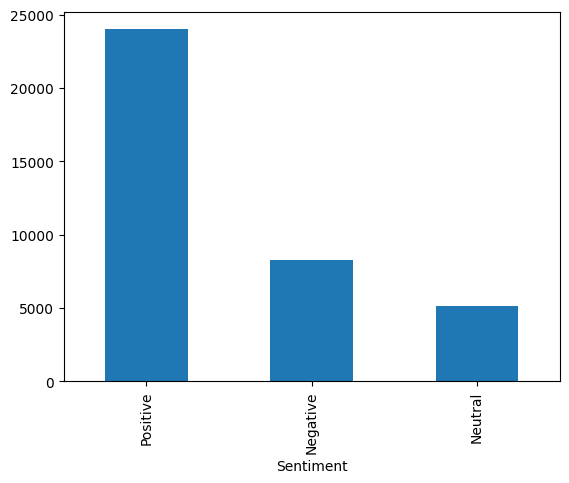

In [4]:
dataframe['Sentiment'].value_counts().plot(kind = 'bar')

Now, from the message we want to predict the type of sentiment. To do this, we will take these two columns out of the dataframe:

In [5]:
dataframe = dataframe[['Translated_Review','Sentiment']]
dataframe.head()

,Translated_Review,Sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
3,Works great especially going grocery store,Positive
4,Best idea us,Positive
5,Best way,Positive


In principle, we have three classes, so we can choose one of two ways:

* Consider a binary classification. We will remove from the dataframe those samples that belong to the `Neutral` category. We will convert the vector `Sentiment` to 0 or 1 depending on whether it is, respectively, negative or positive.
* Consider the classification with the three types. In this case, we will have to formulate an *one-hot* representation.

Starting from the columns we are interested in, the following steps must be carried out in order to unify all the sentences:
- Put all the letters in lower case.
- Remove punctuation marks, converting all the words that were together into separate words.
- Eliminate *stop words*: Short words that have no meaning on their own, such as conjunctions or prepositions.

We define a function that will take care of this, given the phrase `sen` for input:

In [6]:
def preprocess_text(sen):
    # Remove punctuation symbols and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Remove single characters
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Eliminate excess space
    sentence = re.sub(r'\s+', ' ', sentence)

    # Convert to lower case
    sentence = sentence.lower()

    # Eliminate stopwords.
    words = sentence.split()
    filtered_words = [word for word in words if word not in stopwords.words('english')]

    return ' '.join(filtered_words)

In the above function you are referring to the `re` library, which is loaded by default in Python. It is a dedicated library for processing regular expressions. Therefore, we will have to apply the above function to each element of the `Translated_Review` column of the dataframe.

In [7]:
dataframe['Translated_Review'] = dataframe['Translated_Review'].apply(lambda sen: preprocess_text(sen))
dataframe

,Translated_Review,Sentiment
0,like eat delicious food cooking food case best...,Positive
1,help eating healthy exercise regular basis,Positive
3,works great especially going grocery store,Positive
4,best idea us,Positive
5,best way,Positive
...,...,...
64222,ads older many agents much owner posted detail...,Positive
64223,photos posted portal load fit purpose sure sto...,Positive
64226,dumb app wanted post property rent give option...,Negative
64227,property business got link sms happy performan...,Positive


## Vectorial representation of the text

In this section we will aim to convert a text string into a vector, so that it can be treated by the neural network. First, in order to generate the training and validation sets, we will separate the dataframe into two independent variables so that they can be treated separately:

In [8]:
def determine_class(label):
  if label == 'Positive':
    return 0
  elif label == 'Neutral':
    return 1
  elif label == 'Negative':
    return 2

Set the variable to True if you want to remove neutral comments.Otherwise, neutrals will be converted to negative.

In [9]:
REMOVE_NEUTRAL = False

Set the variable to True (as long as the previous one is False) to consider the classes 'Negative' and 'Neutral' equal.

In [10]:
MERGE_NEGATIVE_NEUTRAL = False

In [11]:
if REMOVE_NEUTRAL:
  indexNames = dataframe[dataframe['Sentiment'] == 'Neutral'].index
  dataframe.drop(indexNames , inplace=True)

  y = dataframe['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0).to_numpy()
  #y = tf.one_hot(y, 2)
else:
  if MERGE_NEGATIVE_NEUTRAL:
    y = dataframe['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0).to_numpy()
    #y = tf.one_hot(y, 2)
  else:
    y = dataframe['Sentiment'].apply(lambda x: determine_class(x)).to_numpy()
    #y = tf.one_hot(y, 3)

X = dataframe['Translated_Review']
y = y.astype(numpy.uint8)

[]

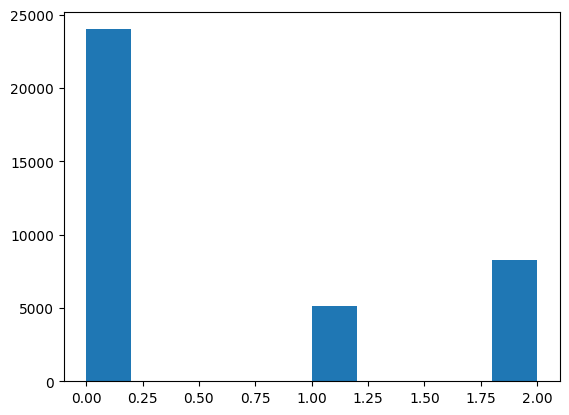

In [12]:
import matplotlib.pyplot as plt

plt.hist(y)
plt.plot()

From the `sklearn` library we can separate into two disjoint sets, containing 80% of the samples for the training set and the remaining for the validation set.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

The next step is to determine the maximum number of words to be used (i.e. the $n$ most frequent first words) and the maximum length of each vector.

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer

NUMBER_OF_WORDS = 20000
MAX_LEN = 100

tokenizer = Tokenizer(num_words = NUMBER_OF_WORDS)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Then, for those sentences that have words that are not among the most frequent, the `padding` technique is used, filling in with zeros those words that are not so frequent and do not appear.


In [17]:
from keras_preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, padding='post', maxlen=MAX_LEN)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_LEN)

## Generate the RNN model

In [18]:
VOCABULARY_SIZE = NUMBER_OF_WORDS
EMBEDDING_SIZE = 128

In [19]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(VOCABULARY_SIZE,
                                    EMBEDDING_SIZE,
                                    input_shape=(X_train.shape[1],)))

model.add(tf.keras.layers.LSTM(units=128, activation='tanh'))

#In units, it must be specified how many classes we have.
model.add(tf.keras.layers.Dense(units=numpy.unique(y_train).shape[0],
                                activation='sigmoid'))

model.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])

model.summary()

model.fit(X_train, y_train, epochs=3, batch_size=128)

c:\Users\Luciano Gabbanelli\anaconda3\envs\Assembler2\Lib\site-packages\keras\src\layers\core\embedding.py:89: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,691,971 (10.27 MB)

 Trainable params: 2,691,971 (10.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
234/234 ━━━━━━━━━━━━━━━━━━━━ 46s 189ms/step - loss: 0.9073 - sparse_categorical_accuracy: 0.6256
Epoch 2/3
234/234 ━━━━━━━━━━━━━━━━━━━━ 42s 181ms/step - loss: 0.8967 - sparse_categorical_accuracy: 0.6398
Epoch 3/3
234/234 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - loss: 0.8978 - sparse_categorical_accuracy: 0.6366


## Test the model

In [20]:
test_loss, test_acurracy = model.evaluate(X_test, y_test)
print("Test accuracy: {}".format(test_acurracy))

234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.9054 - sparse_categorical_accuracy: 0.6307
Test accuracy: 0.6390596032142639
